In [1]:
from Train import *
from initialize import *
from Smaller_RUNet3d import *
from tqdm import tqdm
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

%load_ext autoreload
%autoreload 2

/home/dma14/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Dataset for Brain Images and Cognitve Score

**Returns:** Ximg, Yimg, Yscore, Ascore(whether or not there is as associated score)

In [2]:
df = pd.read_csv('data/cleaned_df_4_26.csv')
X_tr, X_v, y_tr, y_v = get_file_splits()
X_train, X_val, y_adas_train, y_adas_val, y_mmse_train, y_mmse_val = split_train_val(X_tr, X_v, y_tr, y_v, df)

In [3]:
ds_train, ds_val, dl_train, dl_val = get_ds_dl(batch_size=16, num_workers=16)

In [4]:
df

,AGE,PTEDUCAT,APOE4,ADAS11,MMSE,ABETA_bl,TAU_bl,PTAU_bl,M,filenames,...,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,DX_bl_SMC,PTGENDER_Female,PTGENDER_Male,PTGENDER_nan,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married
0,80.40,13,0.00,19.00,21,1002.24,286.52,27.66,6,sub-ADNI100S0006_ses-M06_T1w,...,0,0,1,0,1,0,0,0,1,0
1,80.40,13,0.00,18.67,26,1002.24,286.52,27.66,12,sub-ADNI100S0006_ses-M12_T1w,...,0,0,1,0,1,0,0,0,1,0
2,80.40,13,0.00,11.33,24,1002.24,286.52,27.66,18,sub-ADNI100S0006_ses-M18_T1w,...,0,0,1,0,1,0,0,0,1,0
3,80.40,13,0.00,17.67,22,1002.24,286.52,27.66,36,sub-ADNI100S0006_ses-M36_T1w,...,0,0,1,0,1,0,0,0,1,0
4,80.80,18,1.00,6.67,27,1002.24,286.52,27.66,12,sub-ADNI100S0015_ses-M12_T1w,...,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,74.10,16,0.00,13.33,27,618.50,158.20,14.89,84,sub-ADNI068S4431_ses-M84_T1w,...,0,1,0,0,0,1,0,0,1,0
1639,62.50,18,2.00,35.67,22,413.90,328.30,28.71,96,sub-ADNI018S2133_ses-M96_T1w,...,0,1,0,0,1,0,0,0,1,0
1640,83.80,14,1.00,10.67,28,732.80,228.10,21.48,72,sub-ADNI116S4855_ses-M72_T1w,...,1,0,0,0,0,1,0,0,1,0
1641,75.00,14,1.00,21.33,24,422.80,205.10,19.33,84,sub-ADNI011S4278_ses-M84_T1w,...,1,0,0,0,0,1,0,0,1,0


## Dataset for Brain Images and Cognitve Score

**Returns:** Ximg, Yimg, Yscore, Ascore(whether or not there is as associated score)

In [5]:
X_tr, X_v, y_tr, y_v = get_file_splits()
X_train, X_val, y_adas_train, y_adas_val, y_mmse_train, y_mmse_val = split_train_val(X_tr, X_v, y_tr, y_v, df)

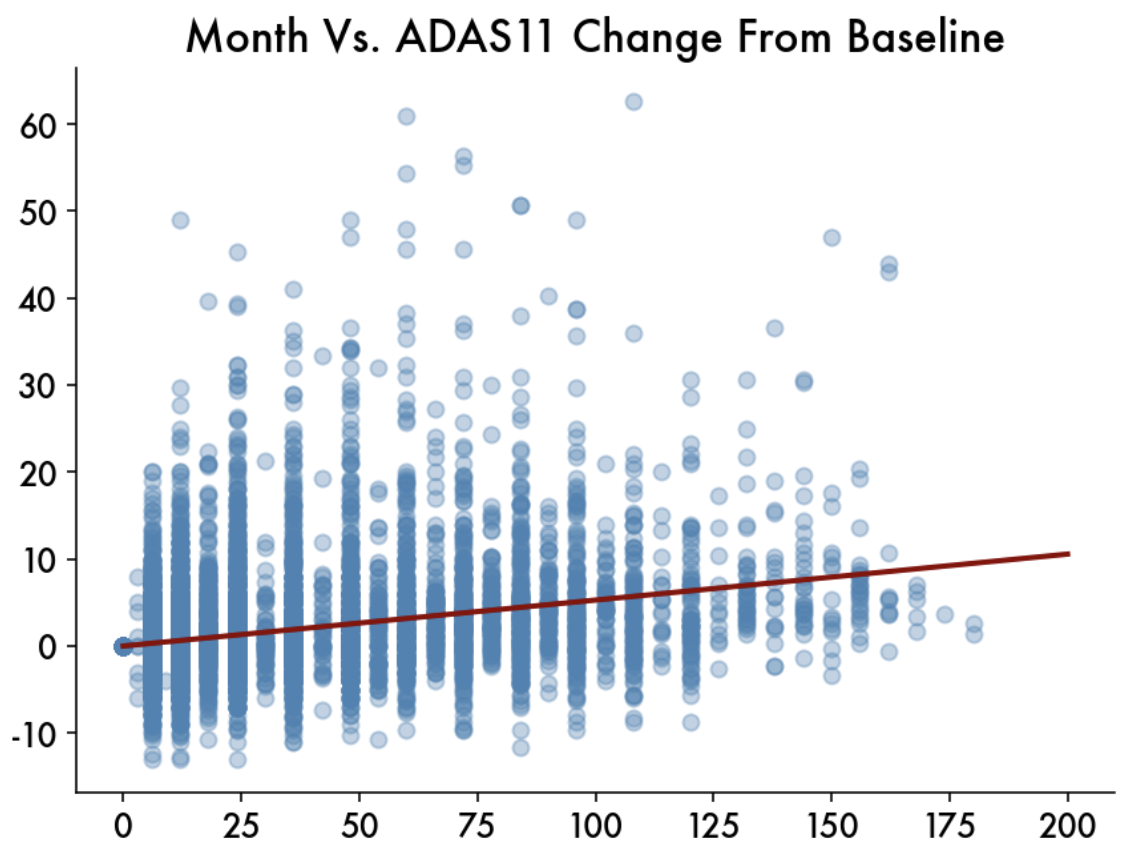


### Process
1. Input: (baseline image, baseline target, current yscore, filename)
2. From baseline image, predict baseline y score (pred_baseline) using U-Net
3. Extract month from filename
4. pred_score = Multiply month by calculated slope + pred_baseline
5. Loss function(pred_score, yscore)

In [7]:
ds_train, ds_val, dl_train, dl_val = get_ds_dl('all', batch_size=32, num_workers=32)

### Create Separate Models For:
1. Current Data - Unet to take baseline image and predict cognitive score
2. Half a year to 2 years (included) - Baseline image to predict (1/2 - 2 years ahead)
3. Two years to four years (included) - Baseline image to predict (2 - 4 years ahead)
4. Four years and up - Baseline image to predict (4+ ahead)

### Filename Text Files For:
1. Current (0 months elapsed) Train, Validation, Test
1. 2-4 years  Train, Validation, Test

In [8]:
X_tr, X_v, y_tr, y_v = get_file_splits()
len(X_tr), len(y_tr), len(X_v), len(y_v)

(1158, 1158, 247, 247)

In [9]:
ds_train, ds_val, dl_train, dl_val = get_ds_dl('all', batch_size=16, num_workers=32)

## Predict Cognitive Score From Current MRI

In [10]:
df

,AGE,PTEDUCAT,APOE4,ADAS11,MMSE,ABETA_bl,TAU_bl,PTAU_bl,M,filenames,...,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,DX_bl_SMC,PTGENDER_Female,PTGENDER_Male,PTGENDER_nan,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married
0,80.40,13,0.00,19.00,21,1002.24,286.52,27.66,6,sub-ADNI100S0006_ses-M06_T1w,...,0,0,1,0,1,0,0,0,1,0
1,80.40,13,0.00,18.67,26,1002.24,286.52,27.66,12,sub-ADNI100S0006_ses-M12_T1w,...,0,0,1,0,1,0,0,0,1,0
2,80.40,13,0.00,11.33,24,1002.24,286.52,27.66,18,sub-ADNI100S0006_ses-M18_T1w,...,0,0,1,0,1,0,0,0,1,0
3,80.40,13,0.00,17.67,22,1002.24,286.52,27.66,36,sub-ADNI100S0006_ses-M36_T1w,...,0,0,1,0,1,0,0,0,1,0
4,80.80,18,1.00,6.67,27,1002.24,286.52,27.66,12,sub-ADNI100S0015_ses-M12_T1w,...,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,74.10,16,0.00,13.33,27,618.50,158.20,14.89,84,sub-ADNI068S4431_ses-M84_T1w,...,0,1,0,0,0,1,0,0,1,0
1639,62.50,18,2.00,35.67,22,413.90,328.30,28.71,96,sub-ADNI018S2133_ses-M96_T1w,...,0,1,0,0,1,0,0,0,1,0
1640,83.80,14,1.00,10.67,28,732.80,228.10,21.48,72,sub-ADNI116S4855_ses-M72_T1w,...,1,0,0,0,0,1,0,0,1,0
1641,75.00,14,1.00,21.33,24,422.80,205.10,19.33,84,sub-ADNI011S4278_ses-M84_T1w,...,1,0,0,0,0,1,0,0,1,0


In [11]:
model = Smaller_RUNet3D(1,4).cuda()
device = torch.device("cuda")
model.to(device)
model = nn.DataParallel(model)
# model.load_state_dict(torch.load(f'/home/cpabalan/brainlabs_cp/3-task_cog/modelsCog3D/regvR2_0.7771_tR2_0.9148.pt'))

model, optim = train(model, dl_train, dl_val, df, epochs=10, learning_rate=0.0001, batch_size=16, device=device)
torch.cuda.empty_cache() 

===== HYPERPARAMETERS =====
batch_size= 16
epochs= 10
learning_rate= 0.0001



  0%|          | 0/730 [00:00<?, ?it/s]

Epoch: 1 
                Train Seg Loss     : 0.9152
                Train Seg Acc      : 0.6629
                Valid Seg Loss     : 0.5544
                Valid Seg Acc      : 0.8235

                Train ADAS Loss    : 115.6837
                Train ADAS Pearson : 0.2907
                Train ADAS R2_score: -0.3525
                Valid ADAS Loss    : 87.1597
                Valid ADAS Pearson : 0.3301
                Valid ADAS R2      : -0.1811


Epoch: 2 
                Train Seg Loss     : 0.3763
                Train Seg Acc      : 0.8778
                Valid Seg Loss     : 0.403
                Valid Seg Acc      : 0.8491

                Train ADAS Loss    : 105.1965
                Train ADAS Pearson : 0.2936
                Train ADAS R2_score: -0.2249
                Valid ADAS Loss    : 88.9231
                Valid ADAS Pearson : 0.2797
                Valid ADAS R2      : -0.1872


Epoch: 3 
                Train Seg Loss     : 0.2831
                Train Seg Acc  

In [ ]:
model, optim = train(model, dl_train, dl_val, df, epochs=10, learning_rate=0.0001, batch_size=16, device=device)
torch.cuda.empty_cache() 

In [ ]:
model, optim = train(model, dl_train, dl_val, df, epochs=10, learning_rate=0.0001, batch_size=16, device=device)
torch.cuda.empty_cache() 